In [82]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from scipy import stats
from pathlib import Path, PureWindowsPath

In [83]:
def extract_dataset_info(data_path):
    # extract information from train.txt
    f = open(os.path.join(data_path, "train.txt"), "r")
    contents_train = f.readlines()
    label_classes, label_train_list, img_train_list = [], [], []
    for sample in contents_train:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        if label not in label_classes:
            label_classes.append(label)
        label_train_list.append(sample[0])
        img_train_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))
    print('Classes: {}'.format(label_classes))

    # extract information from test.txt
    f = open(os.path.join(data_path, "test.txt"), "r")
    contents_test = f.readlines()
    label_test_list, img_test_list = [], []
    for sample in contents_test:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        label_test_list.append(label)
        img_test_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))  # you can directly use img_path if you run in Windows

    return label_classes, label_train_list, img_train_list, label_test_list, img_test_list

In [90]:
def compute_dsift(img):
    # To do
    # Create a sift object.
    sift = cv2.SIFT_create()

    # Stride and Size.
    stride = 200
    size = 8

    # print("Shape of image : ", img.shape)
    u = [i for i in range(0, img.shape[1]-size+1,stride)]   # Plus one was done to consider the last line
    v = [i for i in range(0, img.shape[0]-size+1, stride)]
    X, Y = np.meshgrid(u,v)
    X = (X.ravel() + size//2).astype(float)
    Y = (Y.ravel() + size//2).astype(float)
    # print(X)
    # print(Y)

    # Make Keypoints where you want to calculate the Descriptor.
    keypoints = [cv2.KeyPoint(x, y, size) for (x, y) in zip(X , Y)]

    # Make the descriptors for all the keypoints locations.
    keypoints, dense_feature = sift.compute(img, keypoints)

    return dense_feature

img = cv2.imread("image_0043.jpg",0)
dense_features = compute_dsift(img)
print(dense_features.shape)

(4, 128)


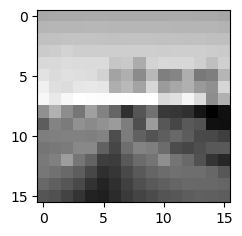

In [85]:
def get_tiny_image(img, output_size):
    # To do
    # img is gray scale image. numpy array.
    # output size will be a tuple of size w,h.

    hor_window_size = img.shape[1] // output_size[1]
    vert_window_size = img.shape[0] // output_size[0]
    feature = np.zeros((output_size))
    for row in range(output_size[0]):
        for col in range(output_size[1]):
            # print("Item here : \n", img[row*vert_window_size :(row+1)*vert_window_size , col*hor_window_size : (col+1)*hor_window_size] )
            feature[row,col] = np.mean(img[row*vert_window_size :(row+1)*vert_window_size , col*hor_window_size : (col+1)*hor_window_size])

    # feature = feature/(hor_window_size*vert_window_size)
    # Normalize the image.

    # print("Feature without Norm : ", feature)
    # print("mean of features  : ", np.mean(feature))
    # print("Max of features : ", np.max(feature))
    # print("Min of features : ", np.min(feature))
    # feature = (feature - np.mean(feature)) / np.std(feature)
    # feature = (feature - np.mean(feature)) / np.max(feature)
    feature = (feature - np.mean(feature)) / 255
    # print("Normalization is incomplete check afterwards.")
    # print("Feature matrix normalized : ", feature)

    return feature

img = cv2.imread("image_0043.jpg",0)
# plt.imshow(img, cmap='grey')
output_size = (16,16)
tiny_image = get_tiny_image(img, output_size)
fig = plt.figure(figsize=(2.5,2.5))
plt.imshow(tiny_image, cmap='grey')

# Trial array.
flat = np.array([i for i in range(256)])
array = flat.reshape((16,16))
# plt.imshow(array,cmap='grey')

In [86]:
def predict_knn(feature_train, label_train, feature_test, k):
    # To do

    # Initialize kNN.
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(feature_train,label_train)

    dist, indices = neigh.kneighbors(feature_test)
    # print("Shape of predict KNN : ", indices.shape)
    # print("Indices in predict knn : ", indices)
    
    # label_test_pred = label_train[indices]
    label_test_pred = [label_train[i] for i in indices[:,0]]
    
    return label_test_pred

In [87]:
def classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do

    output_size = (16,16)

    # Map labels to integers.
    label_map = {key : value+1 for value, key in enumerate(label_classes)}
    label_train_int = np.array([label_map[item] for item in label_train_list])
    label_test_int = np.array([label_map[item] for item in label_test_list])

    label_classes_int = np.array([label_map[item] for item in label_classes])

    # Get the tiny image of all the train items.
    feature_train = np.zeros((len(img_train_list), output_size[0]*output_size[1]))
    for i,path_img in enumerate(img_train_list):
        img = cv2.imread(path_img,0) # Read Image, 0 to read as greyscale.
        feature_train[i,:] = get_tiny_image(img, output_size).flatten()   # Get features using tiny image funtion.

    # Get the tiny image of all the test items.
    feature_test = np.zeros((len(img_test_list), output_size[0]*output_size[1]))
    for i,path_img in enumerate(img_test_list):
        img = cv2.imread(path_img,0) # 0 to read as greyscale.
        feature_test[i,:] = get_tiny_image(img, output_size).flatten()
    
    # Predict labels for the test images.
    k_neighbour = 1
    label_test_pred = predict_knn(feature_train, label_test_int, feature_test, k_neighbour)

    print("Label test Pred : ", label_test_pred)

    # Make the confusion Matrix.
    confusion = np.zeros((len(label_classes), len(label_classes)))
    for row,cls in enumerate(label_classes_int):
        # Get the indices where test data has this item.(ground truth)
        # print("Row is : ", row, " Cls is : ", cls)
        indices = np.where(label_test_int == cls)[0]
        # print("Len of indices in the loop  : ", len(indices))
        # Get the predictions for this class of data.
        preds_temp = np.array([label_test_pred[i] for i in indices])
        # print('preds temps : ', preds_temp)
        for col in range(len(label_classes)):
            # True label for this is cls.
            # confusion[row,col] = np.sum(np.where(preds_temp == label_classes_int[col])) / len(indices)
            confusion[row,col] = np.sum(preds_temp == label_classes_int[col]) / len(indices)
            # print("Confusion Value is : ", confusion[row,col])

    # confusion[0,14] = 1
    print("Max in confution matrix : ", np.max(confusion))
    # Find the accuracy as mean of the correct predictions.
    accuracy = np.mean(np.diagonal(confusion))

    visualize_confusion_matrix(confusion, accuracy, label_classes)

    return confusion, accuracy

classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

KeyboardInterrupt: 

In [92]:
def build_visual_dictionary(dense_feature_list, dict_size):
    # To do

    # For each Image, compute dense SIFT over regular grid.

    ## Assume that dense_feature_list is list of training images.
    # Get the dense features image of all the train items.
    dense_features = np.empty((0,128))
    for i,path_img in enumerate(dense_feature_list):
        img = cv2.imread(path_img,0) # Read Image, 0 to read as greyscale.
        features = compute_dsift(img)
        dense_features = np.vstack((dense_features, features))
        
    print("Shape and Size of Dense Features : ", dense_features.shape)
    
    # Initialize a kmean object.
    kmeans = KMeans(n_clusters=dict_size, init='random', n_init=10 ,max_iter=300)
    # Fit the data into kmeans.
    kmeans.fit(dense_features)

    vocab = kmeans.cluster_centers_
    return vocab

dict_size = 50
vocab = build_visual_dictionary(img_train_list, 50)

Shape and Size of Dense Features :  (5956, 128)


In [104]:
def compute_bow(feature, vocab):
    # To do

    # Find the nearest word to item from feature to vocab.
    # Initailize a nearest neighbour object.
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(vocab)
    distance, indices = neigh.kneighbors(feature)

    # bow_feature = [np.sum(indices == i) for i in range(vocab.shape[0])]
    bow_feature = np.bincount(indices[:,0], minlength=vocab.shape[0])
    # print("Bow feature : ", bow_feature)
    # print("Len of bow : " , len(bow_feature))

    # Normalize the bow_features.
    bow_feature = bow_feature / np.linalg.norm(bow_feature)

    # print(bow_feature)

    return bow_feature

img = cv2.imread("image_0043.jpg",0)
feature = compute_dsift(img)
bow_feature = compute_bow(feature, vocab)

In [ ]:
def classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do
    
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

In [ ]:
def predict_svm(feature_train, label_train, feature_test, n_classes):
    # To do
    return label_test_pred

In [ ]:
def classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

In [ ]:
def visualize_confusion_matrix(confusion, accuracy, label_classes):
    plt.title("accuracy = {:.3f}".format(accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()

In [ ]:
if __name__ == '__main__':
    # To do: replace with your dataset path
    label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info("./scene_classification_data")
    
    # classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

    # classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)
    
    # classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']


In [ ]:
print(len(label_classes))
type(label_classes)

In [ ]:
print(len(label_train_list))
print(label_train_list[0])

In [ ]:
len(label_train_list)

In [ ]:
len(label_test_list)

In [ ]:
len(label_test_list)
label_test_list[0]